In [27]:
import sys
sys.path.append("../")

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from library import regulations
from library import analysis
from library import tables


In [2]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/descriptive/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'master_data_district.csv'),
                  sep=",")
data.sample(5)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,year,district,distname,distischarter,rating_academic,rating_financial,type,type_description,cntyname,...,district_status,type_urban,type_suburban,type_town,type_rural,eligible,teachers_nodegree,teachers_badegree,teachers_msdegree,teachers_phddegree
4672,4672,2015,203902,BROADDUS ISD,N,M,Pass,H,RURAL,SAN AUGUSTINE,...,doi,0,0,0,1,1,0.000000,0.872881,0.127119,0.000000
3013,3013,2014,102901,KARNACK ISD,N,I,NaN,H,RURAL,HARRISON,...,doi,0,0,0,1,1,0.000000,0.844958,0.155042,0.000000
3564,3564,2014,227825,AUSTIN ACHIEVE PUBLIC SCHOOLS,Y,I,NaN,I,CHARTER SCHOOL DISTRICTS,TRAVIS,...,charter,0,0,0,0,0,0.000000,0.512320,0.487680,0.000000
8075,8075,2018,152910,IDALOU ISD,N,B,Pass,D,OTHER CENTRAL CITY SUBURBAN,LUBBOCK,...,doi,0,1,0,0,1,0.001267,0.845374,0.153359,0.000000
6729,6729,2017,114901,BIG SPRING ISD,N,M,Pass,E,INDEPENDENT TOWN,HOWARD,...,doi,0,0,1,0,1,0.011499,0.818321,0.162514,0.007666


In [3]:
data = data[data.year == 2016]
data = data[data.doi == True]
data.sample(5)
data.teachers_turnover_ratio.hist()

# Teacher Turnover

In [4]:
bins = [0,10, 20, 30, 100]
labels = ['<10%', '10%-20%', '20%-30%', '>30%']
data['bins']  = pd.cut(data['teachers_turnover_ratio'], bins, labels = labels)
data[['bins', 'teachers_turnover_ratio']].sample(5)

,bins,teachers_turnover_ratio
5872,20%-30%,23.9
5652,10%-20%,16.5
5698,10%-20%,14.1
5243,10%-20%,13.1
6097,20%-30%,21.1


In [5]:
data['bin10'] = np.where(data.bins == '<10%', 1, 0)
data['bin20'] = np.where(data.bins == '10%-20%', 1, 0)
data['bin30'] = np.where(data.bins == '20%-30%', 1, 0)
data['bin100'] = np.where(data.bins == '>30%', 1, 0)

In [6]:
list(data.bins.value_counts())

[413, 230, 95, 74]

In [13]:
def create_count_proportion_df(data, list_of_regs):
    n_col = []
    p_10 = []
    p_20 = []
    p_30 = []
    p_100 = []
    reg_labels = []
    f_p = []

    for reg in list_of_regs:
        n_col.append((len(data[data[reg] == 1])))
        p_10.append(data[data.bin10 == 1][reg].mean().round(2))
        p_20.append(data[data.bin20 == 1][reg].mean().round(2))
        p_30.append(data[data.bin30 == 1][reg].mean().round(2))
        p_100.append(data[data.bin100 == 1][reg].mean().round(2))
        reg_labels.append(regulations.labels[reg])
        formula = reg + '~ bin20 + bin30 + bin100'
        df = data.dropna(subset=['students_hisp', reg])
        results = smf.ols(formula, data=df).fit()
        f_p.append(results.f_pvalue.round(2))

    df = pd.DataFrame(
            {'Regulation': reg_labels,
             'Count': n_col,
             '<10%': p_10,
             '10%-20%': p_20,
             '20%-30%': p_30,
             '>30%': p_100,
             'F-test p-value': f_p
             })
    return df

In [14]:
columns = ['Count', '<10%', '10%-20%', '20%-30%', '>30%', 'F-test p-value']
schedules_df = create_count_proportion_df(data, list_of_regs = regulations.schedules)
tables.df_to_excel(file = table_path + 'desc_exemptionsXturnover.xlsx', df = schedules_df,
                  df_columns = columns, start_row = 5, start_col = 3)
schedules_df

,Regulation,Count,<10%,10%-20%,20%-30%,>30%,F-test p-value
0,25.0811 - Minimum First Day of Instruction,798,0.98,0.96,0.98,0.97,0.66
1,25.081 - Minimum Minutes of Operation,356,0.42,0.42,0.44,0.49,0.77
2,25.0812 - Minimum Last Day of Instruction,231,0.31,0.27,0.32,0.20,0.26
3,25.082 - Pledge of Allegiance and Minute of Si...,208,0.21,0.26,0.27,0.23,0.75


In [15]:
class_size_df = create_count_proportion_df(data, list_of_regs = regulations.class_size)
tables.df_to_excel(file = table_path + 'desc_exemptionsXturnover.xlsx', df = class_size_df,
                  df_columns = columns, start_row = 10, start_col = 3)
class_size_df

,Regulation,Count,<10%,10%-20%,20%-30%,>30%,F-test p-value
0,25.112 - Class Size Maximum,363,0.44,0.45,0.44,0.43,0.99
1,25.113 - Notice of Class Size,299,0.36,0.36,0.36,0.41,0.89
2,25.111 - Maximum Student Teacher Ratio,127,0.12,0.17,0.14,0.14,0.54


In [16]:
certification_df = create_count_proportion_df(data, 
                                                 list_of_regs = regulations.certification)
tables.df_to_excel(file = table_path + 'desc_exemptionsXturnover.xlsx', df = certification_df,
                  df_columns = columns, start_row = 14, start_col = 3)
certification_df

,Regulation,Count,<10%,10%-20%,20%-30%,>30%,F-test p-value
0,21.003 - Teacher Certification Required,714,0.87,0.88,0.85,0.92,0.37
1,21.053 - Presentation of Teacher Certificates,240,0.32,0.28,0.31,0.28,0.88
2,21.057 - Notice of Uncertified Teacher,271,0.36,0.29,0.37,0.41,0.11


In [17]:
contracts_df = create_count_proportion_df(data, 
                                                 list_of_regs = regulations.contracts)
tables.df_to_excel(file = table_path + 'desc_exemptionsXturnover.xlsx', df = contracts_df,
                  df_columns = columns, start_row = 18, start_col = 3)
contracts_df

,Regulation,Count,<10%,10%-20%,20%-30%,>30%,F-test p-value
0,21.102 - Maximum Probationary Contract Length,419,0.45,0.49,0.56,0.57,0.13
1,21.401 - Minimum Service Days Required for Tea...,290,0.42,0.27,0.40,0.57,0.00
2,21.352 - Teacher Evaluation,166,0.23,0.20,0.19,0.19,0.74
3,21.354 - Administrator Evaluation,46,0.11,0.05,0.04,0.05,0.11


In [18]:
behavior_df = create_count_proportion_df(data, 
                                                 list_of_regs = regulations.behavior)
tables.df_to_excel(file = table_path + 'desc_exemptionsXturnover.xlsx', df = behavior_df,
                  df_columns = columns, start_row = 23, start_col = 3)
behavior_df

,Regulation,Count,<10%,10%-20%,20%-30%,>30%,F-test p-value
0,25.092 - Minimum Attendance for Class Credit,214,0.18,0.30,0.22,0.30,0.01
1,37.0012 - Designation of Campus Behavior Coord...,178,0.21,0.25,0.17,0.19,0.13
2,25.036 - Transfers,178,0.26,0.16,0.26,0.34,0.00


# Scatter plot

In [62]:
bins = [0, 5, 10, 15, 20, 25, 30, 100]
labels = ['5%', '10%', '15%', '20%', '25%', '30%', '35%+']
data['bins']  = pd.cut(data['teachers_turnover_ratio'], bins, labels = labels)


,bins,count,p,std,min,25%,50%,75%,max
0,5%,13.0,0.692308,0.480384,0.0,0.0,1.0,1.0,1.0
1,10%,82.0,0.378049,0.487884,0.0,0.0,0.0,1.0,1.0
2,15%,199.0,0.241206,0.428894,0.0,0.0,0.0,0.0,1.0
3,20%,214.0,0.299065,0.458922,0.0,0.0,0.0,1.0,1.0
4,25%,141.0,0.368794,0.484198,0.0,0.0,0.0,1.0,1.0
5,30%,89.0,0.438202,0.498978,0.0,0.0,0.0,1.0,1.0
6,35%+,74.0,0.567568,0.498795,0.0,0.0,1.0,1.0,1.0


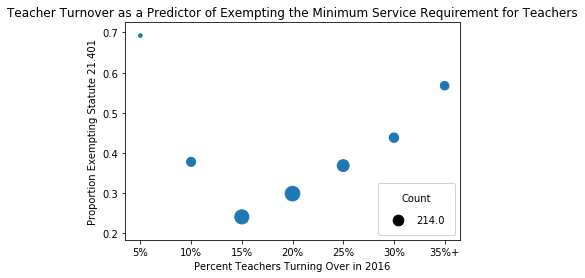

In [78]:
df = data[['bins', 'reg21_401']].groupby('bins')['reg21_401'].describe().reset_index().rename(columns = {'mean': 'p'})
plt.scatter(df.bins, df.p, s = df['count'])

plt.ylabel('Proportion Exempting Statute 21.401')
plt.xlabel('Percent Teachers Turning Over in 2016')
plt.title('Teacher Turnover as a Predictor of Exempting the Minimum Service Requirement for Teachers')

pws = (pd.cut(df['count'], bins=4, retbins=True)[1]).round(0)
for pw in pws:
    plt.scatter([], [], s=df['count'], c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[5:], l[5:], labelspacing=1.2, title="Count", borderpad=1, 
            frameon=True, framealpha=0.9, loc=4, numpoints=1)

plt.gca()

In [72]:
pws

array([ 13.,  63., 114., 164., 214.])

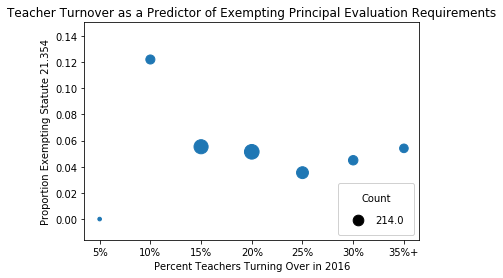

In [82]:
df = data[['bins', 'reg21_354']].groupby('bins')['reg21_354'].describe().reset_index().rename(columns = {'mean': 'p'})

plt.scatter(df.bins, df.p, s = df['count'])

plt.ylabel('Proportion Exempting Statute 21.354')
plt.xlabel('Percent Teachers Turning Over in 2016')
plt.title('Teacher Turnover as a Predictor of Exempting Principal Evaluation Requirements')

pws = (pd.cut(df['count'], bins=4, retbins=True)[1]).round(0)
for pw in pws:
    plt.scatter([], [], s=df['count'], c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[5:], l[5:], labelspacing=1.2, title="Count", borderpad=1, 
            frameon=True, framealpha=0.9, loc=4, numpoints=1)

plt.gca()

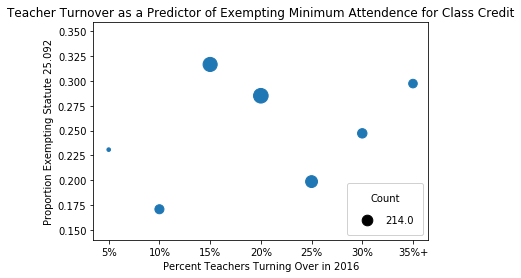

In [83]:
df = data[['bins', 'reg25_092']].groupby('bins')['reg25_092'].describe().reset_index().rename(columns = {'mean': 'p'})

plt.scatter(df.bins, df.p, s = df['count'])

plt.ylabel('Proportion Exempting Statute 25.092')
plt.xlabel('Percent Teachers Turning Over in 2016')
plt.title('Teacher Turnover as a Predictor of Exempting Minimum Attendence for Class Credit')

pws = (pd.cut(df['count'], bins=4, retbins=True)[1]).round(0)
for pw in pws:
    plt.scatter([], [], s=df['count'], c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[5:], l[5:], labelspacing=1.2, title="Count", borderpad=1, 
            frameon=True, framealpha=0.9, loc=4, numpoints=1)

plt.gca()

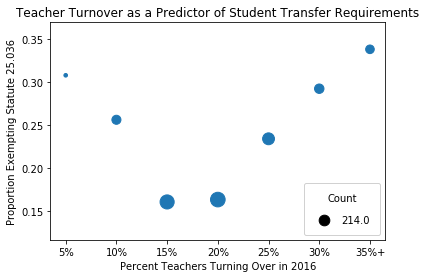

In [84]:
df = data[['bins', 'reg25_036']].groupby('bins')['reg25_036'].describe().reset_index().rename(columns = {'mean': 'p'})

plt.scatter(df.bins, df.p, s = df['count'])

plt.ylabel('Proportion Exempting Statute 25.036')
plt.xlabel('Percent Teachers Turning Over in 2016')
plt.title('Teacher Turnover as a Predictor of Student Transfer Requirements')

pws = (pd.cut(df['count'], bins=4, retbins=True)[1]).round(0)
for pw in pws:
    plt.scatter([], [], s=df['count'], c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[5:], l[5:], labelspacing=1.2, title="Count", borderpad=1, 
            frameon=True, framealpha=0.9, loc=4, numpoints=1)

plt.gca()